# Imports

In [25]:
import torch, torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [9]:
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 1.13.1
torchvision version: 0.14.1


# Loading Data

In [6]:
to_tensor = transforms.ToTensor()

In [11]:
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=to_tensor)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=to_tensor)

In [14]:
train_data[0][0].shape, train_data[0][1]

(torch.Size([1, 28, 28]), 9)

In [18]:
classes = train_data.classes
classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Label: Shirt


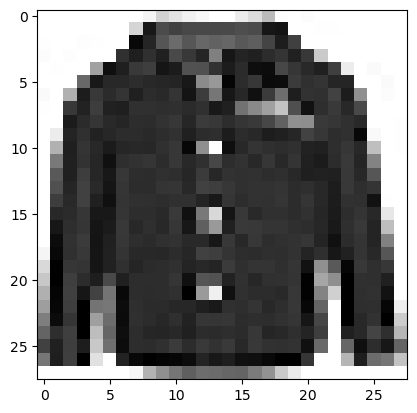

In [23]:
sample_id = torch.randint(0, len(train_data), size=(1,)).item()
sample = train_data[sample_id]
print(f"Label: {classes[sample[1]]}")
plt.imshow(sample[0].squeeze(), cmap='binary');

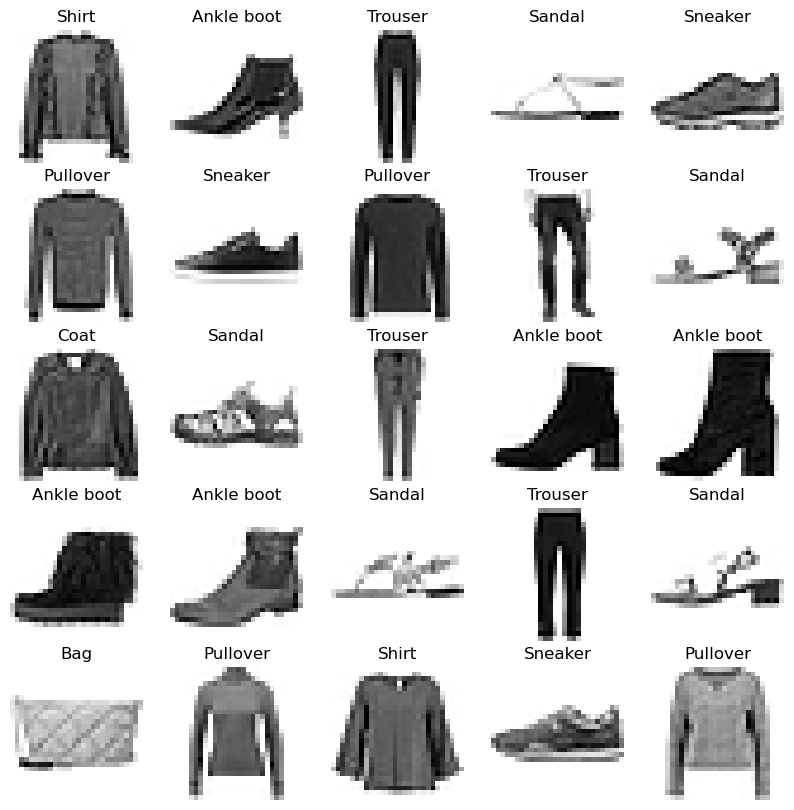

In [24]:
row = 5
col = 5
fig, axes = plt.subplots(row, col, figsize=(10, 10))
for i in range(row):
    for j in range(col):
        randi_int = torch.randint(0, len(train_data), size=(1,)).item()
        axes[i, j].imshow(train_data[randi_int][0].squeeze(), cmap='binary')
        axes[i, j].set_title(classes[train_data[randi_int][1]])
        axes[i, j].axis('off')

In [26]:
BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [28]:
class Model0(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(784, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        return x
    
model0 = Model0()
model0

Model0(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [29]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model0.parameters(), lr=0.001)

In [30]:
def train_step(model, loss_fn, optimizer, x, y):
    model.train()
    yhat = model(x)
    l = loss_fn(yhat, y)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    return l.item()

def test_step(model, loss_fn, x, y):
    model.eval()
    yhat = model(x)
    l = loss_fn(yhat, y)
    return l.item()

In [33]:
def accuracy(model, x, y):
    model.eval()
    yhat = model(x)
    yhat = torch.argmax(yhat, dim=1)
    return torch.sum(yhat == y).item() / len(y)

In [37]:
EPOCHS = 5
for epoch in range(EPOCHS):
    train_loss = 0
    test_loss = 0
    for i, (x, y) in enumerate(train_loader):
        train_loss += train_step(model0, loss, optimizer, x, y)
        print(f"Epoch: {epoch+1:>2d}/{EPOCHS:>2d} | Batch: {i+1:>3d}/{len(train_loader):>3d} | Loss: {train_loss/(i+1):.4f}", end='\r')
    train_acc = accuracy(model0, x, y)
    for x, y in test_loader:
        test_loss += test_step(model0, loss, x, y)
    test_acc = accuracy(model0, x, y)
    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    print(f"Epoch: {epoch+1:>2d}/{EPOCHS:>2d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Epoch:  1/ 5 | Train Loss: 0.3920 | Train Acc: 0.8438 | Test Loss: 0.4411 | Test Acc: 0.8750
Epoch:  2/ 5 | Train Loss: 0.3896 | Train Acc: 0.9688 | Test Loss: 0.4531 | Test Acc: 0.8125
Epoch:  3/ 5 | Train Loss: 0.3868 | Train Acc: 0.8750 | Test Loss: 0.4505 | Test Acc: 0.8125
Epoch:  4/ 5 | Train Loss: 0.3843 | Train Acc: 0.9062 | Test Loss: 0.4483 | Test Acc: 0.8125
Epoch:  5/ 5 | Train Loss: 0.3827 | Train Acc: 0.7812 | Test Loss: 0.4757 | Test Acc: 0.9375


In [39]:
def predict(model, x):
    model.eval()
    yhat = model(x)
    yhat = torch.argmax(yhat, dim=1)
    return yhat

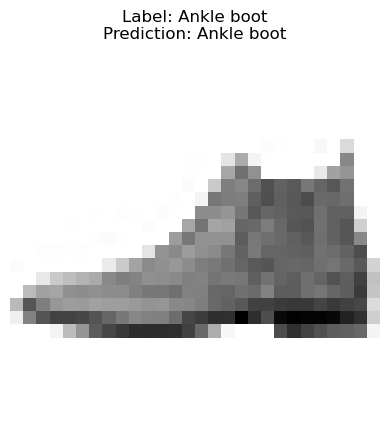

In [40]:
def plot_sample(x, y, yhat, classes):
    plt.imshow(x.squeeze(), cmap='binary')
    plt.title(f"Label: {classes[y]}\nPrediction: {classes[yhat]}")
    plt.axis('off')

x, y = test_data[0]
yhat = predict(model0, x.unsqueeze(0))
plot_sample(x, y, yhat, classes)

In [47]:
class Conv1(nn.Module):
    def __init__(self, color_channel: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=color_channel, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [50]:
conv_model = Conv1(1, 10, 10)
conv_model

Conv1(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [51]:
conv_loss = nn.CrossEntropyLoss()
conv_optimizer = torch.optim.Adam(conv_model.parameters(), lr=0.001)

EPOCHS = 5
for epoch in range(EPOCHS):
    train_loss = 0
    test_loss = 0
    for i, (x, y) in enumerate(train_loader):
        train_loss += train_step(conv_model, conv_loss, conv_optimizer, x, y)
        print(f"Epoch: {epoch+1:>2d}/{EPOCHS:>2d} | Batch: {i+1:>3d}/{len(train_loader):>3d} | Loss: {train_loss/(i+1):.4f}", end='\r')
    train_acc = accuracy(conv_model, x, y)
    for x, y in test_loader:
        test_loss += test_step(conv_model, conv_loss, x, y)
    test_acc = accuracy(conv_model, x, y)
    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    print(f"Epoch: {epoch+1:>2d}/{EPOCHS:>2d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Epoch:  1/ 5 | Train Loss: 0.5193 | Train Acc: 0.7812 | Test Loss: 0.4016 | Test Acc: 0.8750
Epoch:  2/ 5 | Train Loss: 0.3437 | Train Acc: 0.8438 | Test Loss: 0.3402 | Test Acc: 0.8750
Epoch:  3/ 5 | Train Loss: 0.3028 | Train Acc: 0.9688 | Test Loss: 0.3310 | Test Acc: 0.9375
Epoch:  4/ 5 | Train Loss: 0.2796 | Train Acc: 0.9062 | Test Loss: 0.2960 | Test Acc: 0.8125
Epoch:  5/ 5 | Train Loss: 0.2632 | Train Acc: 0.9375 | Test Loss: 0.2830 | Test Acc: 0.8125
